In [78]:
from pandas import read_csv, concat
from seaborn import FacetGrid, lineplot, move_legend

from matplotlib import pyplot as plt
import squarify
import numpy as np

# The Data
## Overview

2.

(2a)
* What sources - brief description, give some headline assumptions
  * UNPD
  * GBD
  * Earth4All
(2b)
* Scenarios we're focusing on, maybe a plot in here with headline assumptions
  * UNPD: High, Med, Low
  * GBD: Reference, SDG Met Need
  * Earth4All: Too Little Too Late, Giant Leap

## Initial look at the data
3.
(3a)
* Methodology
  * Multiple ways to pull data from UNPD, API or catalogue of downloads, downloading csv simpler for exploratory work (haven't decided what we're looking for) but for specific datasets I've got some simple bits of python to wrap the API and pull in specific datasets
  * At least for UNPD (picture is a little more complex for other forecasts) most of the useful/interesting metrics are either in the data or a relatively simple calculation
  * One big project-specific question is "when are the Next 8 Billion born?"
  * Set methodology here.
  * Note that not all forecasts have a next 8 bn this century - suggest one could do a simple extrapolation but this overlooks the complexity of the forecasts and all the assumptions that will be broken in doing this.
* When do we reach 8 Billion?
  * Plot of cumulative births since 2023
  * Maybe add (faint) lines for specific forecasts?
  * Plot all births as well, make it a births-focused section
* Population stats
  * Total population
  * Median age
  * Dependency ratio
  * Do all of above grouped by income groups
  * G20, P20
  
# Dave wrap up

In [57]:
""" Load all data here """
""
datapaths = [ # load these iteratively
    "../../data/prepared_data/gbd_world_births.csv",
    "../../data/prepared_data/unpd_world_indicators.csv",
    "../../data/prepared_data/cumulative_births_unpd_all_countries.csv",
    "../../data/prepared_data/e4a_combined_labelled.csv"
]

df_gbd_births, df_unpd_world, df_unpd_cumul, df_e4a = [
    read_csv(dpath) for dpath in datapaths
]

# bigger datasets (need to unset low mem opt.) - del these from mem when out of scope
df_all_locs = concat(
    [
        read_csv("../../data/unpd_data/WPP2022_Demographic_Indicators_Medium.csv", low_memory=False),
        read_csv("../../data/unpd_data/WPP2022_Demographic_Indicators_OtherVariants.csv", low_memory=False)
    ])

metadata = read_csv("../../data/metadata/UNSD — Methodology.csv", delimiter=";")

In [50]:
regions = [r for r in metadata["Region Name"].unique() if r is not np.nan]
sub_regions = [r for r in metadata["Sub-region Name"].unique() if r is not np.nan]

print(metadata.columns)

Index(['Global Code', 'Global Name', 'Region Code', 'Region Name',
       'Sub-region Code', 'Sub-region Name', 'Intermediate Region Code',
       'Intermediate Region Name', 'Country or Area', 'M49 Code',
       'ISO-alpha2 Code', 'ISO-alpha3 Code', 'Least Developed Countries (LDC)',
       'Land Locked Developing Countries (LLDC)',
       'Small Island Developing States (SIDS)'],
      dtype='object')


Index(['Unnamed: 0', 'Variant', 'Time', 'Location', 'BirthsSingle'], dtype='object')


(0.0, 100.0, 0.0, 100.0)

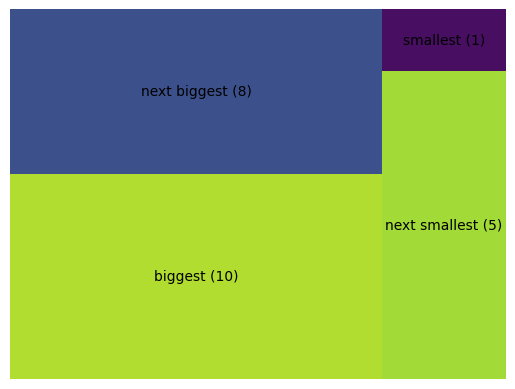

In [15]:
# in case we want to use this later

print(df_unpd_cumul.columns)

#df_unpd_cumul[df_unpd_cumul.Variant=="Medium"]

test_data = {
             "biggest": 10,
             "next biggest": 8,"next smallest": 5,
             "smallest": 1
            }
squarify.plot(test_data.values(), label=[f"{k} ({v})" for k,v in test_data.items()])
plt.axis("off")

In [71]:
df_combined_global = concat(
    [df_unpd_world,
    df_gbd_births.loc[:,["val","year_id","scenario_name"]].rename(columns={
        "val": "BirthsSingle",
        "year_id": "Time",
        "scenario_name": "Variant"}),
    df_e4a.loc[:,["Births","scenario","year_id"]].rename(columns={
        "Births": "BirthsSingle",
        "year_id": "Time",
        "scenario": "Variant"})
    ]).reset_index()

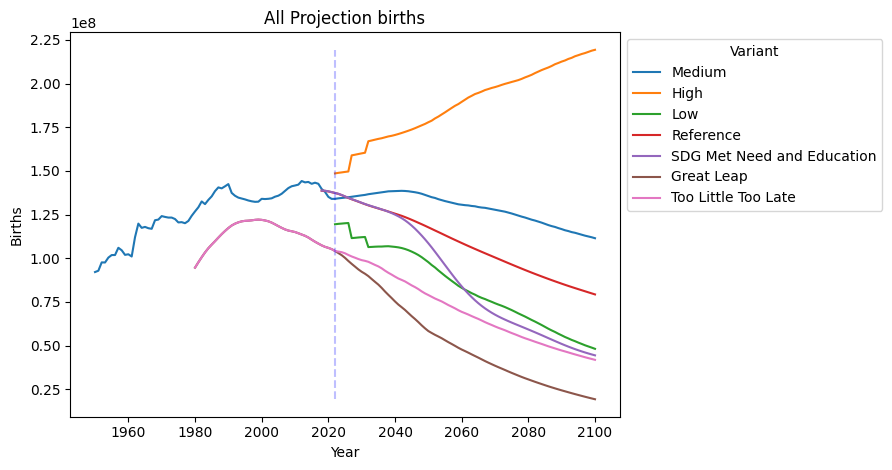

In [83]:
df_combined_global

ax = lineplot(data=df_combined_global, x="Time", y="BirthsSingle", hue="Variant")
plt.title("All Projection births")
plt.xlabel("Year")
plt.ylabel("Births")
plt.vlines(2022,
           df_combined_global.BirthsSingle.min(),
           df_combined_global.BirthsSingle.max(),
           color="b",linestyle="dashed", alpha=0.25)
plt.tight_layout()
move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [75]:
cumulative_births_comb = df_combined_global[df_combined_global.Time > 2022]\
    .sort_values(["Variant","Time"], ascending=True)\
    .set_index(["Variant","Time"])\
    .groupby("Variant")\
    .BirthsSingle\
    .cumsum()\
    .reset_index()

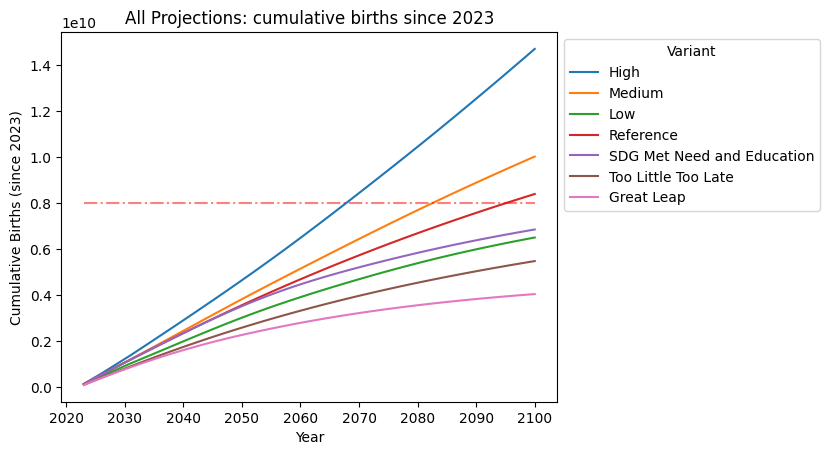

In [82]:
ax = lineplot(data=cumulative_births_comb,
             x="Time",
             y="BirthsSingle",
             hue="Variant",
             hue_order=["High",
                        "Medium",
                        "Low",
                        "Reference",
                        "SDG Met Need and Education",
                        "Too Little Too Late",
                        "Great Leap"]
             )
plt.title("All Projections: cumulative births since 2023")
plt.xlabel("Year")
plt.ylabel("Cumulative Births (since 2023)")
plt.hlines(8e9, 2023, 2100, color="r",linestyle="dashdot", alpha=0.5)
move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [51]:
unpd_regional_cumul = df_unpd_cumul[df_unpd_cumul.Location.apply(lambda r: r in regions)]
unpd_subregional_cumul = df_unpd_cumul[df_unpd_cumul.Location.apply(lambda r: r in sub_regions)]

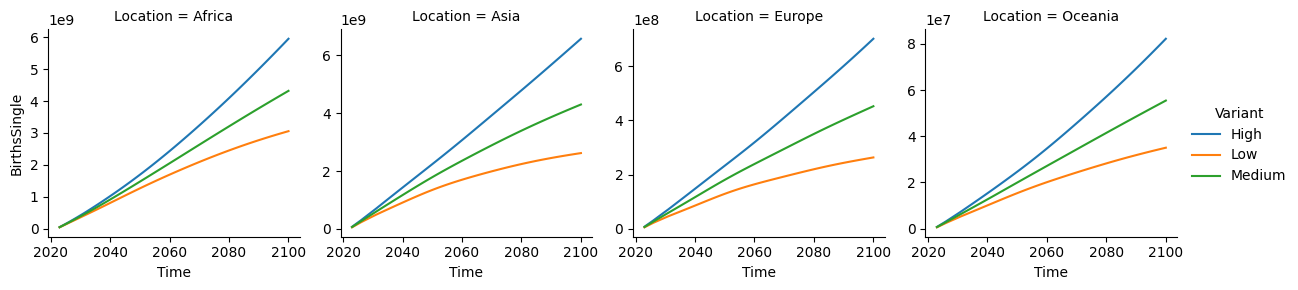

In [53]:
# TODO: work out where missing countries are and do this in a later section with appropriate strata (may need different data)

f = FacetGrid(data=unpd_regional_cumul,
              col="Location",
              col_wrap=None,
              hue="Variant",
              sharex=True,
              sharey=False)
f.map(lineplot, "Time", "BirthsSingle")
f.add_legend()
#             hue="Variant")
#plt.title("UNPD: cumulative births since 2023")
#plt.xlabel("Year")
#plt.ylabel("Cumulative Births (since 2023)")
#plt.hlines(8e9, 2023, 2150, color="r",linestyle="dashdot", alpha=0.5)
#plt.show()

In [56]:
df_unpd_cumul.Location.value_counts()

Location
Latin America and the Caribbean                  468
Australia/New Zealand                            468
Afghanistan                                      234
Oman                                             234
Oceania (excluding Australia and New Zealand)    234
                                                ... 
Guam                                             234
Guatemala                                        234
Guernsey                                         234
Guinea                                           234
Zimbabwe                                         234
Name: count, Length: 284, dtype: int64